In [1]:
import pandas as pd
import pickle

# Chargement des DataFrames à partir des fichiers pickle
filtered_tokenized_vs_original = pd.read_pickle('filtered_tokenized_vs_original.pkl')
top200_tags = pd.read_pickle('top200_tags.pkl')
svm_clf = pd.read_pickle('svm_clf.pkl')
mlb =  pd.read_pickle('mlb.pkl')
tfidf_vectorizer = pd.read_pickle('tfidf_vectorizer.pkl')
vocabulary = pd.read_pickle('vocabulary.pkl')
pca = pd.read_pickle('pca.pkl')

# Méthode non supervisée : LDA

# Recherche du modèle ayant l'indice de cohérence maximum

In [2]:
%%time 

import gensim
from gensim.models import TfidfModel
import gensim.corpora as corpora
from gensim import models
from gensim.utils import simple_preprocess
from gensim.models.ldamulticore import LdaMulticore
from gensim.models import CoherenceModel
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
import matplotlib.pyplot as plt


def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Args:
  
        dictionary : Gensim dictionary
        corpus : Gensim corpus
        texts : List of input texts
        limit : Max num of topics

    Returns:
    
        model_list : List of LDA topic models
        coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    
    
    for num_topics in range(start, limit, step):
        
        model = LdaMulticore(corpus=corpus,
                            id2word=dictionary,
                            num_topics=num_topics, 
                            random_state=42,
                            passes=10,
                            workers=7)

        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values



CPU times: total: 688 ms
Wall time: 714 ms


Applying TF-IDF: 100%|████████████████████████████████████████████████████████| 41371/41371 [00:00<00:00, 84829.62it/s]
2024/03/04 15:25:28 INFO mlflow.tracking.fluent: Experiment with name 'modele LDA' does not exist. Creating a new experiment.
Calculating Coherence:   0%|                                                                    | 0/49 [00:00<?, ?it/s]C:\Users\etern\anaconda3v2\Lib\site-packages\gensim\models\ldamodel.py:847: RuntimeWarning: divide by zero encountered in scalar divide
  perwordbound = self.bound(chunk, subsample_ratio=subsample_ratio) / (subsample_ratio * corpus_words)
Calculating Coherence: 100%|███████████████████████████████████████████████████████████| 49/49 [07:58<00:00,  9.77s/it]


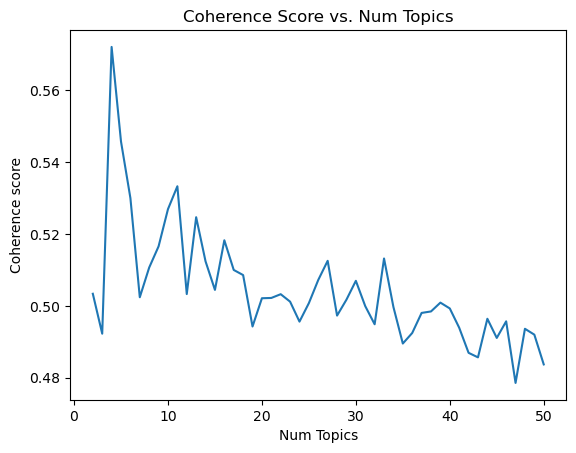

Num Topics = 2  has Coherence Value of 0.5033
Num Topics = 3  has Coherence Value of 0.4922
Num Topics = 4  has Coherence Value of 0.5721
Num Topics = 5  has Coherence Value of 0.5457
Num Topics = 6  has Coherence Value of 0.53
Num Topics = 7  has Coherence Value of 0.5024
Num Topics = 8  has Coherence Value of 0.5106
Num Topics = 9  has Coherence Value of 0.5165
Num Topics = 10  has Coherence Value of 0.5269
Num Topics = 11  has Coherence Value of 0.5333
Num Topics = 12  has Coherence Value of 0.5033
Num Topics = 13  has Coherence Value of 0.5247
Num Topics = 14  has Coherence Value of 0.5124
Num Topics = 15  has Coherence Value of 0.5044
Num Topics = 16  has Coherence Value of 0.5182
Num Topics = 17  has Coherence Value of 0.51
Num Topics = 18  has Coherence Value of 0.5086
Num Topics = 19  has Coherence Value of 0.4942
Num Topics = 20  has Coherence Value of 0.5021
Num Topics = 21  has Coherence Value of 0.5022
Num Topics = 22  has Coherence Value of 0.5032
Num Topics = 23  has Cohe

In [28]:
import pandas as pd
from tqdm import tqdm
from gensim import corpora
from gensim.models import TfidfModel
from gensim.utils import simple_preprocess
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
import mlflow

# Charger les données après le nettoyage
data = pd.read_pickle("./data/cleaned_corpus.pkl")

# Remplacer les valeurs NaN dans la colonne 'splitted_text' par des chaînes vides
data['splitted_text'] = data['splitted_text'].fillna('')

# Assurez-vous que toutes les valeurs de 'splitted_text' sont de type str
data['splitted_text'] = data['splitted_text'].astype(str)

# Créer le dictionnaire Gensim
texts = [simple_preprocess(text) for text in tqdm(data['splitted_text'].to_list(), desc="Preprocessing texts")]
id2word = corpora.Dictionary(texts)
id2word.filter_extremes(no_below=1000)

# Créer le corpus BoW et appliquer le modèle TF-IDF
bow_corpus = [id2word.doc2bow(text) for text in tqdm(texts, desc="Creating BoW Corpus")]
tfidf = TfidfModel(bow_corpus)
tfidf_corpus = [tfidf[text] for text in tqdm(bow_corpus, desc="Applying TF-IDF")]

# Définir l'emplacement MLflow
mlflow.set_tracking_uri("http://localhost:5000")

# Définir le nom de l'expérience
mlflow.set_experiment("modele LDA")

# Calculer la cohérence pour différents nombres de sujets
start, limit, step = 2, 51, 1
model_list, coherence_values = [], []

for num_topics in tqdm(range(start, limit, step), desc="Calculating Coherence"):
    with mlflow.start_run():
        lda_model = LdaModel(corpus=tfidf_corpus, id2word=id2word, num_topics=num_topics)
        coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
        coherence_score = coherence_model.get_coherence()

        # Logguer le modèle dans MLflow
        mlflow.log_param("num_topics", num_topics)
        mlflow.log_metric("coherence_score", coherence_score)

        model_list.append(lda_model)
        coherence_values.append(coherence_score)
        
    # Terminer l'exécution MLflow à la fin de chaque itération
    mlflow.end_run()

# Tracer la courbe de cohérence en fonction du nombre de sujets
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.title("Coherence Score vs. Num Topics")
plt.show()

# Afficher les valeurs de cohérence pour chaque nombre de sujets
for num_topics, coherence_score in zip(x, coherence_values):
    print("Num Topics =", num_topics, " has Coherence Value of", round(coherence_score, 4))


In [4]:
#on garde le meilleur score, ici 12 

# Indices de log perplexité, de cohérence et du top 20 des tags les plus représentés par topic

In [5]:
%%time
from pprint import pprint
optimal_model = model_list[10]

print('\nPerplexity: ', optimal_model.log_perplexity(tfidf_corpus))

coherence_model_lda = CoherenceModel(model=optimal_model, texts=texts, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=30))


Perplexity:  -5.627072786723927

Coherence Score:  0.5090061762715898
[(0,
  '0.382*"array" + 0.207*"order" + 0.092*"code" + 0.074*"anyone" + '
  '0.056*"result" + 0.051*"index" + 0.031*"create" + 0.020*"number" + '
  '0.017*"help" + 0.016*"solution" + 0.014*"column" + 0.006*"work" + '
  '0.006*"print" + 0.006*"blockquote" + 0.005*"error" + 0.001*"time" + '
  '0.001*"quot" + 0.001*"function" + 0.001*"name" + 0.000*"reference" + '
  '0.000*"http" + 0.000*"href" + 0.000*"file" + 0.000*"documentation" + '
  '0.000*"application" + 0.000*"output" + 0.000*"something" + 0.000*"list" + '
  '0.000*"input" + 0.000*"noreferrer"'),
 (1,
  '0.082*"code" + 0.041*"quot" + 0.025*"class" + 0.024*"blockquote" + '
  '0.022*"database" + 0.021*"access" + 0.019*"http" + 0.018*"state" + '
  '0.018*"error" + 0.015*"function" + 0.015*"time" + 0.014*"point" + '
  '0.014*"value" + 0.013*"user" + 0.013*"file" + 0.012*"name" + 0.012*"href" + '
  '0.011*"server" + 0.011*"example" + 0.011*"return" + 0.011*"noreferr

# Test du topic dominant, des mots clés associés des documents du corpus

In [6]:
print

<function print(*args, sep=' ', end='\n', file=None, flush=False)>

In [7]:
%%time

original_post = data['Post']
original_cleaned_keywords = data['splitted_tags']

def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame(columns=['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords'])

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df.loc[i] = [int(topic_num), round(prop_topic,4), topic_keywords]

    # Add original text to the end of the output
    sent_topics_df['Text'] = pd.Series(texts).values

    return sent_topics_df

df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=tfidf_corpus, texts=original_post)


# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic = pd.concat([df_dominant_topic, original_cleaned_keywords], axis=1)
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text', 'Original_keywords']

# Show
df_dominant_topic.head(10)

CPU times: total: 33.8 s
Wall time: 33.9 s


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Original_keywords
0,0.0,5.0,0.6742,"imgur, stack, http, image, code, noreferrer, h...",react router v5 2 blocking route change with...,"[javascript, reactjs, react, router, react, ro..."
1,1.0,1.0,0.7816,"code, quot, class, blockquote, database, acces...",rolling idxmin max for pandas dataframe p i b...,"[python, panda, dataframe, indexing, rolling, ..."
2,2.0,4.0,0.5264,"quot, code, google, name, request, client, mes...",process finished with exit code 137 interrupt...,"[python, panda, numpy, pycharm]"
3,3.0,4.0,0.7683,"quot, code, google, name, request, client, mes...",flutter web text field scrolls instead of se...,"[textfield, selection, flutter]"
4,4.0,11.0,0.7124,"java, code, class, quot, auto, method, context...",can t scrape all the company names from a webp...,"[python, python, scraping, python, request]"
5,5.0,6.0,0.2815,"code, package, list, github, http, node, insta...",got can t resolve react jsx runtime error wh...,"[reactjs, typescript, storyboard, rollup]"
6,6.0,4.0,0.7956,"quot, code, google, name, request, client, mes...",next image not taking class properties p i am...,"[reactjs, next, tailwind, nextjs, image]"
7,7.0,5.0,0.5094,"imgur, stack, http, image, code, noreferrer, h...",push existing folder to gitlab p in gitlab pr...,"[gitlab, gitlab, commit]"
8,8.0,10.0,0.4775,"text, column, color, style, task, code, quot, ...",how to solve cors error when redirecting to gi...,"[ruby, rail, reactjs, axios, cors, github, oauth]"
9,9.0,8.0,0.7361,"quot, code, const, import, react, component, e...",how do i load the celeba dataset on google col...,"[python, pytorch, dataset, torchvision, pytorc..."


# Document le plus significatif par topic

In [8]:
%%time

sent_topics_sorteddf = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf

CPU times: total: 31.2 ms
Wall time: 19 ms


,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0,0.6849,"array, order, code, anyone, result, index, cre...",NaN
1,1,0.8500,"code, quot, class, blockquote, database, acces...",NaN
2,2,0.8146,"python, model, code, line, file, print, quot, ...",NaN
3,3,0.6630,"service, test, info, documentation, json, appl...",NaN
4,4,0.8606,"quot, code, google, name, request, client, mes...",NaN
5,5,0.8599,"imgur, stack, http, image, code, noreferrer, h...",NaN
6,6,0.8125,"code, package, list, github, http, node, insta...",NaN
7,7,0.8531,"quot, code, version, project, command, error, ...",NaN
8,8,0.8476,"quot, code, const, import, react, component, e...",NaN
9,9,0.8016,"code, value, size, type, number, class, functi...",NaN


# Répartition des topics

In [9]:
%%time 
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = sent_topics_sorteddf[["Topic_Num","Keywords"]]

# Concatenate Column wise
df_dominant_topics_prop = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics_prop.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics_prop

CPU times: total: 0 ns
Wall time: 3 ms


,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,0,"array, order, code, anyone, result, index, cre...",19836,0.4795
1,1,"code, quot, class, blockquote, database, acces...",2067,0.0500
2,2,"python, model, code, line, file, print, quot, ...",1163,0.0281
3,3,"service, test, info, documentation, json, appl...",98,0.0024
4,4,"quot, code, google, name, request, client, mes...",3402,0.0822
5,5,"imgur, stack, http, image, code, noreferrer, h...",3264,0.0789
6,6,"code, package, list, github, http, node, insta...",1832,0.0443
7,7,"quot, code, version, project, command, error, ...",2647,0.0640
8,8,"quot, code, const, import, react, component, e...",2591,0.0626
9,9,"code, value, size, type, number, class, functi...",2318,0.0560


# Fonction de prédiction

In [10]:
%%time
def predict_supervised_tags(supervised_model, mlb_model, text):
    """
    Predict tags according to a lemmatized text using a supervied model.
    
    Args:
        supervised_model(): Used mode to get prediction
        mlb_model(): Used model to detransform
    Returns:
        res(list): List of predicted tags
    """
    res = tfidf_vectorizer.transform(text)
    res = pd.DataFrame(res.toarray(), columns=vocabulary)
    res = pca.transform(res)
    res = supervised_model.predict(res)
    res = mlb.inverse_transform(res)
    res = list({tag for tag_list in res for tag in tag_list if (len(tag_list) != 0)})
    res = [tag for tag  in res if tag in text]
    
    return res

CPU times: total: 0 ns
Wall time: 0 ns


2024/03/04 16:26:42 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\etern\AppData\Local\Temp\tmpt00_9dus\model, flavor: python_function). Fall back to return ['cloudpickle==2.2.1']. Set logging level to DEBUG to see the full traceback. 


In [61]:
lda_model = optimal_model
def predict_unsupervised_tags(text):
    """
    Predict tags of a preprocessed text
    
    Args:
        text(list): preprocessed text
        
    Returns:
        relevant_tags(list): list of tags
    """
    
    corpus_new = id2word.doc2bow(text)
    topics = lda_model.get_document_topics(corpus_new)
    
    #find most relevant topic according to probability
    relevant_topic = topics[0][0]
    relevant_topic_prob = topics[0][1]
    
    for i in range(len(topics)):
        if topics[i][1] > relevant_topic_prob:
            relevant_topic = topics[i][0]
            relevant_topic_prob = topics[i][1]
            
    #retrieve associated to topic tags present in submited text
    potential_tags = lda_model.get_topic_terms(topicid=relevant_topic, topn=20)
    
    relevant_tags = [id2word[tag[0]] for tag in potential_tags if id2word[tag[0]] in text]
    
    return relevant_tags

In [65]:
lda_model_final = lda_model

In [66]:
# Enregistrez les poids du modèle LDA
lda_model_final.save("lda_model.gensim")
# Enregistrez le dictionnaire Gensim
with open("id2word.pkl", "wb") as file:
    pickle.dump(id2word, file)

In [62]:
optimal_model

# Fonction de vérification

In [13]:
filtered_tokenized_vs_original_1 = filtered_tokenized_vs_original.dropna(subset=['Post']).reset_index(drop=True)


In [19]:
def check_tag_predction(original_text, original_tags, preprocessed_text, supervised_model):
    """
    Check original tags vs predicted tags for a post.
    
    Args:
        post(list) : original text
        original_tags(list) : preprocessed_tags
    """
    
    predicted_supervised_tags = predict_supervised_tags(supervised_model, mlb, preprocessed_text)
    predicted_unsupervised_tags = predict_unsupervised_tags(preprocessed_text)
    print("Publication originale: \n")
    print(f"{original_text}")
    print("\n")
    print(f"Liste des tags pré-traités utilisés par l'utilisateur: {original_tags}")
    print("\n")
    print(f"Liste des tags prédits par le modèle supervisé: {predicted_supervised_tags}")
    print("\n")
    print(f"Liste des tags prédits par le modèle non supervisé: {predicted_unsupervised_tags}")

print("Test des 10 premiers documents du corpus\n")
for i in range(10):
    print(f"Document {i}:")
    print("\n")
    check_tag_predction(filtered_tokenized_vs_original_1.loc[i,'Post'], 
                    filtered_tokenized_vs_original.loc[i,'splitted_tags'],
                    filtered_tokenized_vs_original.loc[i,'splitted_text'],
                    svm_clf)
    print("-"*100 + "\n")

Test des 10 premiers documents du corpus

Document 0:


Publication originale: 

react router v5 2   blocking route change with createbrowserhistory and history block  p my app has two pages   code step1  code  and  code step2  code    code step1  code  has a checkbox that blocks navigation if it is checked and a next button that navigates to  code step2  code  when clicked   code step2  code  has a previous button that navigates back to  code step1  code  when clicked   p 
 p  strong  a href  https   codesandbox io s react router createbrowserhistory w historyblock zoybv file  example js 346 762  rel  noreferrer  link to demo  a   strong   p 
 p as per this  a href  https   youtu be kt1ewqba7aa t 572  rel  noreferrer  tutorial  a   i m using the  code block  code  method of the  code createbrowserhistory  code  object to block route changes if the checkbox in  code step1  code  is checked   p 
 pre  code const unblock   useref   

  useeffect      gt   
    unblock current   history b

Publication originale: 

how do i load the celeba dataset on google colab  using torch vision  without running out of memory   p i am following a tutorial on  a href  https   pytorch org tutorials beginner dcgan_faces_tutorial html  rel  nofollow noreferrer  dcgan  a   whenever i try to load the celeba dataset  torchvision uses up all my run time s memory 12gb  and the runtime crashes  am looking for ways on how i can load and apply transformations to the dataset without hogging my run time s resources   p 
 h2 to reproduce  h2 
 p here is the part of the code that is causing issues   p 
 pre class  lang py prettyprint override   code   root directory for the dataset
data_root    data celeba 
  spatial size of training images  images are resized to this size 
image_size   64

celeba_data   datasets celeba data_root 
                              download true 
                              transform transforms compose  
                                  transforms resize image_size  
 

In [60]:
with open('filtered_tokenized_vs_original_1.pkl', 'wb') as f:
    pickle.dump(filtered_tokenized_vs_original_1, f)

In [50]:
import mlflow
import pickle
from gensim.models import LdaModel
from gensim.corpora import Dictionary

# Assumez que lda_model est votre modèle LDA entraîné et id2word est votre dictionnaire Gensim
# Assurez-vous d'avoir ces objets correctement définis avant d'exécuter ce code

# Enregistrez les poids du modèle LDA
lda_model.save("lda_model.gensim")
# Enregistrez le dictionnaire Gensim
with open("id2word.pkl", "wb") as file:
    pickle.dump(id2word, file)

# Enregistrez le modèle dans MLflow
with mlflow.start_run():
    # Enregistrez les poids du modèle
    mlflow.log_artifact("lda_model.gensim", artifact_path="model")
    # Enregistrez le dictionnaire
    mlflow.log_artifact("id2word.pkl", artifact_path="model")


In [52]:
import mlflow
import pickle
from gensim.models import LdaModel
from gensim.corpora import Dictionary

# Assumez que lda_model est votre modèle LDA entraîné et id2word est votre dictionnaire Gensim
# Assurez-vous d'avoir ces objets correctement définis avant d'exécuter ce code

# Enregistrez les poids du modèle LDA
lda_model.save("lda_model.gensim")
# Enregistrez le dictionnaire Gensim
with open("id2word.pkl", "wb") as file:
    pickle.dump(id2word, file)

# Enregistrez le modèle dans MLflow
with mlflow.start_run():
    # Enregistrez les poids du modèle
    mlflow.log_artifact("lda_model.gensim", artifact_path="model")
    # Enregistrez le dictionnaire
    mlflow.log_artifact("id2word.pkl", artifact_path="model")

    # Récupérez le run_id de l'exécution en cours
    run_id = mlflow.active_run().info.run_id

    # Spécifiez le chemin du modèle en tant qu'URI modèle
    model_uri = f"runs:/{run_id}/model"

    # Enregistrez le modèle dans le registre
    model_name = "lda_model"
    model_version = mlflow.register_model(model_uri=model_uri, name=model_name)


Registered model 'lda_model' already exists. Creating a new version of this model...
2024/03/04 16:50:34 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: lda_model, version 1
Created version '1' of model 'lda_model'.


In [23]:
check_tag_predction(filtered_tokenized_vs_original_1.loc[100,'Post'], 
                filtered_tokenized_vs_original.loc[100,'splitted_tags'],
                filtered_tokenized_vs_original.loc[100,'splitted_text'],
                svm_clf)

Publication originale: 

space required to keep largest integer array in memory  p i am reviewing an algorithm and it keeps an array of integers  the size of input is dynamic  so according to my calculations it can take as much as  p 
 pre  code   integer max_value    int size        
      2 31 integers    4 bytes      
2147483648 integers    4 bytes     8 gigabytes
  code   pre 
 p is this calculation correct   would the jvm use this much contiguous space to store the int array or are there other things that one needs to consider    p 



Liste des tags pré-traités utilisés par l'utilisateur: ['java', 'memory', 'management']


Liste des tags prédits par le modèle supervisé: ['array', 'memory']


Liste des tags prédits par le modèle non supervisé: ['code', 'value', 'size', 'input', 'array']


In [20]:
def evaluate_tags(predicted_tags, actual_tags):
    common_tags = set(predicted_tags) & set(actual_tags)
    precision = len(common_tags) / len(predicted_tags) if len(predicted_tags) > 0 else 0
    recall = len(common_tags) / len(actual_tags) if len(actual_tags) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f1_score

In [21]:
evaluate_tags(filtered_tokenized_vs_original_1.loc[100,'Post'], 
                filtered_tokenized_vs_original.loc[100,'splitted_tags'],
                filtered_tokenized_vs_original.loc[100,'splitted_text'],
                svm_clf)

TypeError: evaluate_tags() takes 2 positional arguments but 4 were given